# Advanced Topics of Graph ML

## Subgraph Problem

One of the fundamental problems of graph theory and computer science is the problem of counting the number of times a given subgraph appears within a larger parent graph. This problem can now be cast as a machine learning problem.

Give a graph $G=(V,E)$, either: (the definition used depends on the domain of study)
1. $G'$ is a subgraph of $G$ (node) *induced* by $V'$, where $G'=(V',E')$ such that $V'\subseteq V$ and $E'=\{(u,v)\in E | u,v\in V'\}$
2. $G'$ is a subgraph of $G$ (edge) *induced* by $E'$, where $G'=(V',E')$ such that $E'\subseteq E$ and $V'=\{v\in V | (v,u)\in E'\}$

Further, as these definitions require the subgraph to be taken from the original parent, *isomorphism* (whether graphs are identical - graph isomorphism has not been proven to be an NP-hard problem but no polynomial algorithm has been found) needs to be defined such that an un-related sugraph can be defined for a parent. $G_1=(V_1,E_1)$ amd $G_2=(V_2,E_2)$ are *isomorphic* if there exists a bijection (one-to-one) $f:V_1\rightarrow V_2$ such that $(u,v)\in E_1 \leftrightarrow (f(u),f(v))\in E_2$ ($f$ is called the *isomorphism*). Therefore, $G_2$ is *subgraph-isomorphic* (known to be NP-hard) to $G_1$ if some subgraph of $G_2$ is *isomorphic* to $G_1$ (commonly say $G_1$ is a subgraph of $G_2$)

***Network Motifs*** are recurring (high frequency), significant (more frequent than expected) patterns (small subgraphs) of interconnections. *Network Motifs* are important as they help in teh understanding of how the graph dataset works (e.g. feed-forward loops motifs found in networks of neurons were found to be used for neutralising "biological noise", etc.) and are a useful tool to make predictions based on their (lack of) presence in the dataset.

Subgraph frequency is defined by the number of nodes $u$ in $G_T$ for which some subgraph of $G_T$ is isomorphic to $G_Q$ and the isomorphism maps node $u$ to $v$. Let $(G_Q,v)$ be called a *node-anchored* subgraph (robust to outliers). Thus, is a subgraphs occurs in a real network more often than in a **random network** it is considered to have functional significance:
- **Erdos-Renyi Random Graphs**: $G_{n,p}$ is an undirected graph on $n$ nodes where each edge $(u,v)$ appears independent and identically distributed with probability $p$.
- **Configuration Model**: $G^{rand}$ is a random graph with given degree sequence $k_1,\ldots,k_N$; generated by creating for each node $i$, $k_i$ mini-nodes and randomly connecting these mini-nodes (no self-loops), afterwhich coalescing back the mini-nodes, retaining their connections within the parent node (coalesce similar connections).

And so to determine is *motifs* are overrepresented in a network can be done by statistical measures (z-score, etc.) to evaluate how significant is the difference between the *motif* count in the real graph vs the random graph with similar statistics (node number, edges, degree sequence, etc.) for each *motif*.

### Isomorphism as an ML task

Instead of combinatorial matching to identify whether the graph and subgraph are isomorphic, a GNN can be used to predict subgraph isomorphism (binary prediction). The high level approach can be to decompose the input graph into neighbourhoods and embed each such that a prediction can be made against them with the embeddings of the query subgraph. To make this robust (similar to the subgraph frequencies), node-anchored definitions will be utilised; therefore will allow  isomorphism detection as well as identify the corresponding nodes.

Breadth-first search can be used to obtain $k$-hop neighbourhood around any given anchor-node (hyperparameter $k$) for both $G_T$ and $G_Q$, with the embedding being done using GNN.

The embedding space will be such that a graph $A$ is mapped to a point $Z_A\geq 0$ (non-negative in all dimensions); so that it can capture the partial ordering (transitivity) $A \preceq B$ and $B \preceq C$, then $A \preceq C$ ($x \preceq y$ denotes that the emebdding of $x$ is less than or equal to $y$ in all of its coordinates). Subgraph isomorphism relationship can be nicely encoded in this order embedding space: (subgraph embedding being at the lower-left of a neighbourhood embedding which includes the given subgraph)
- **Transitivity**: if $G_1$ is a subgraph of $G_2$, and $G_2$ is a subgraph of $G_3$, then $G_1$ is a subgraph of $G_3$ ($A \preceq B \cap B \preceq C \rightarrow A \preceq C$).
- **Anti-Symmetry**: if $G_1$ is a subgraph of $G_2$, and $G_2$ is a subgraph of $G_1$, then $G_1$ is isomorphic to $G_2$ ($A \preceq B \cap B \preceq A \rightarrow A = B$).
- **Closure Under Intersection**: the trivial graph of 1 node is a subgraph of any graph ($0 \preceq X,\;\forall X$).

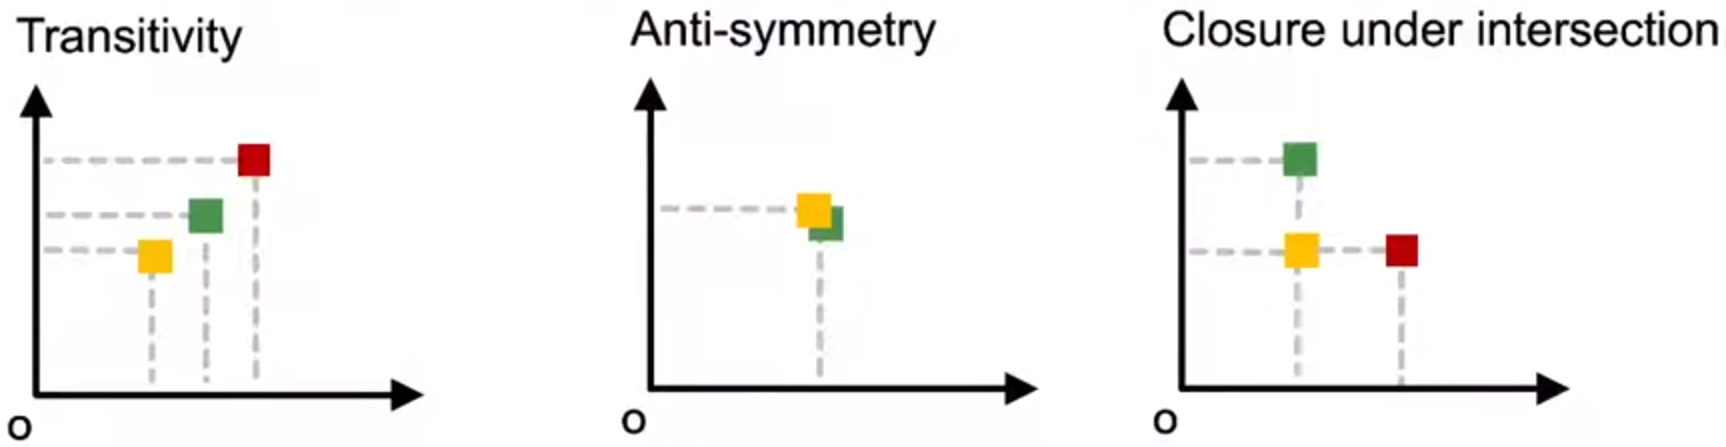

Thus, for the GNN to learn neighbourhood embedding that preserve the order embedding structure, a loss function based on the *order constraint* (ideal order embedding property that reflects subgraph relationships): $$\forall_{i=1}^DZ_q[i]\leq Z_u[i] \leftrightarrow G_Q\subseteq G_T$$
GNN embedding will then be learnt by minimizing the ***max-margin loss*** $E(G_q, G_t)=\sum_{i=1}^D\max(0, Z_q[i]-Z_t[i])^2$ (margin between graphs $G_q$ and $G_t$), meaning that if $E(G_q,G_t)=0\rightarrow G_q\subseteq G_t$ and if $E(G_q,G_t)>0\rightarrow G_q\not\subseteq G_t$. 

To learn such embeddings, both positive and negative examples must be constructed, where for positive examples ($G_q\subseteq G_t$) the objective would be $\min E(G_q,G_t)$, and negative examples ($G_q\not\subseteq G_t$) $\min \max(0, \alpha-E(G_q,G_t))$ (prevents the model from learning degenerate strategy of moving embeddings further and further apart forever). These examples (query $G_Q$ and target $G_T$) can be generated from a dataset $G$ by iteratively choosing a random anchor $v$ and taking a $k$-hop neighbourhood of $G$ to be $G_T$; then sample induced subgraph $G_Q$ of $G_T$ using BFS sampling with initial $S=\{v\}, V=\emptyset$. At every step (depth hyperparameter, usually 3-5), sample $p%$ of the nodes $N(S)\not\in V$ and add them into $S$; the remaining nodes of $N(S)$ in $V$ (prevents a fully connected subgraph). For the negative example, corrupt $G_Q$ by adding or remove an edge or a node so it is no longer a subgraph. At every iteration, the model sees a different subgraph examples which improves performance and avoids overfitting (exponential number of possible subgraph to sample from).

Predictions are then done when given a query graph $G_q$ anchored at a node $q$, target graph $G_t$ anchored at node $t$, then if $E(G_q,G_t)<\epsilon$, predict "True"; else "False" (hyperparameter $\epsilon$). To check if $G_Q$ is isomorphic to a subgraph of $G_T$, repeat this procedure for all $q\in G_Q$, $t\in G_T$.

### Frequent Motif Mining
Give a target graph $G_T$, identify among all possible graphs of $k$ nodes, the $r$ graphs with the highest frequency in $G_T$ (using node-level definition). Traditionally, while logically simple is computationally intensive due to subgraph isomorphism being NP-complete, adn exponential growth of subgraph per node count.

Utilising the order embedding space previously mentioned, frequency of a given subgraph can be quickly predicted by counting the embeddings smaller than it; and so decompose $G_T$ into node-anchored neighbourhoods $G_{N_i}$ and estimate the frequency of $G_Q$ by counting the number of $G_{N_i}$ such that their embeddings $Z_{N_i}$ satisfy $z_Q\leq z_{N_i}$ (consequence of teh order embedding space property).

Now a search procedure must be defines so not all the subgraph permulations would be searched. starting with a randomly picked node $u$ in the target graph $G_T$ (subgraph in all neighbourhoods), set $S=\{u\}$; then, iteratively grow the motif by choosing a neighbor in $G_T$ of a node in $S$ and add that node to $S$. The choice of neighbour node added to $S$ is done by minimising the total violations (number of neighbourhoods that do not satisfy $z_Q\preceq z_{N_i}$), done through a greedy strategy where at every step, the node that results in the smallest total violations is added.

## GNNs for Recommender Systems
Recommender systems can baturally be modeled as a *bipartite* graphs; where given past user-item interactions predictions are made of new items each user will interact with in the future.

As many of these graph systems contain millions of items and users, evaluating each user-item pair is not feasible. Instead, $K$ candidates are generated (10-100) with the goal being to include as many positive items (items that the user does interact with in the future) as possible in the "top-$K$ recommended items"; implemented maximising ***Recall@$K$*** (for user $u$, $\frac{|P_u \cap R_u|}{|P_u|}$). This is then followed by a slower, ranking model which assigns suitability scores to all $K$ items and thereby ranking them.

To get the top-$K$ items, a score function for user-item interaction is needed; such that for user, $u\in U$, and item, $v\in V$, a real-value scalar is produced $\text{score}(u,v)$ with $K$ items with the largest scores being chosen (excluding already interacted items). To achieve this, encoders for both $u\in U\rightarrow \{u\}_{u\in U}\in\mathbb{R}^D$ and $v\in V\rightarrow \{v\}_{v\in V}\in\mathbb{R}^D$ must be implemented as well as a parametrized scoring function $f_{\theta}:\mathbb{R}^D\times\mathbb{R}^D\rightarrow\mathbb{R}$.

*Recall@$K$* however is not differentiable and thus cannot apply efficient gradient-based optimization; however, there are differentaible loss functions which align with the original objective (surrogate functions):
- **Binary Loss**: given a set of positive edges $E_{pos}$ (observed/training user-item interactions) and negative edges $E_{neg}=\{(u,v)|(u,v)\in E_{pos},u\in U, v\in V\}$, the binary loss function, $-\frac{1}{|E_{pos}}|\sum_{(u,v)\in E_{pos}}\log(\sigma(f_{\theta}(u,v)))-\frac{1}{|E_{neg}}|\sum_{(u,v)\in E_{neg}}\log(1-\sigma(f_{\theta}(u,v))):\sigma(x)=\frac{1}{1+\exp(-1)}$, pushes the scores of positive edges higher than those of negative edges aligning with *Recall@$K$* since positive edges need to be recalled. This however, pushes all positive edges higher than those of all negative edges, unnecessarily penalize model predictions even when training *Recall@$K$* is perfect; this is due to being non-personalised in the sense that teh positive/negative edges are considered across all users at once where *Recall@$K$* is inherently personalised.
- **Bayesian Personalized Ranking**: BPR loss is a personalised surrogate loss that aligns better with *Recall@$K$* by defining rooted positive/negative edges $E_{pos}(u^*)=\{(u^*,v)|(u^*,v)\in E_{pos}\}$ and $E_{neg}(u^*)=\{(u^*,v)|(u^*,v)\in E_{neg}\}$, such that a rooted loss function can be defined $\text{Loss}(u^*)=\frac{1}{|E_{pos}(u^*)|\cdot|E_{neg}(u^*)|}\sum_{(u^*,v_{pos})\in E_{pos}(u^*)}\sum_{(u^*,v_{neg})\in E_{neg}(u^*)}-\log(\sigma(f_{\theta}(u^*,v_{pos})-f_{\theta}(u^*,v_{neg})))$ with teh final BPR loss being the average of all rooted loss $\frac{1}{|U|}\sum_{u^*\in U}\text{Loss}(u^*)$. Doing this fully is computationally expensive where in practive mini-batch training is prefered.

### Neural Graph Collaborative Filtering
Conventional collaborative filtering models are based on shallow encoders for users and items,  $u\in U, v\in V\rightarrow z_u,z_v\in\mathbb{R}^D$, such that the score function is naively $f(u,v)\equiv z_u^{\text{T}}z_u$ where the model itself only implicitly captures the graph structure via the training objective (edges).

GNNs on the other hand are a natural approach to acheive explicit capturing of the graph structure and capture high-order graph structures beyond first-order edge connectivity. NGCF works by initialy preparing shallow learnable embeddings for each node and then using multi-layer GNNs to propagate the embeddings along the bipartite graph to generate the final embeddings which are explicitly graph-aware (score function is the inner product).
### LightGCN
LightGCN simpliefies NGCF by removing the GNN learnable parameters. This is done as the shallow embedding has been observed to have alot of expressiveness and is additionally easier to learn ($O(ND)$) than the GNN parameters ($O(N^2)$); further it has been shown to improve the recommendation performance by preventing overfitting (*diffusion* encourages the embedding of similar users/items to be similar).

The normalized adjacency matrix can be written as $\tilde{A}\equiv D^{-1/2}AD^{-1/2}$ where $D$ is the degree matrix of adgacency matrix $A$. Thereby, each GCN's aggregation can be written in a single matrix form $E^{(k+1)}=\text{ReLU}(\tilde{A}E^{(k)}W^{(k)})$; and simplifying the GCN by removing $\text{ReLU}$ =, the final node embedding matrix is given as $E^{(k+1)}=\tilde{A}E^{(k)}W^{(k)}=\tilde{A}(\tilde{A}E^{(k-1)}W^{(k-1)})W^{(k)}=\ldots=\tilde{A}^kE^{(0)}(W^{(0)}\ldots W^{(k)})$ which significantly simplifies the GCN, and by further removing teh learnable parameters, $W$, the results is the *diffusion* node embeddings along the graph $E^{(k)}=\tilde{A}^{k}E$ (apply $E\leftarrow =\tilde{A}E$ for $k$ times), where each matrix multiplication diffuses the current embeddings to their one-hop neighbours ($=\tilde{A}^{k}$ is dense and never gets materialized, instead the iterative matrix-vector product is used).

Multi-scale *diffusion* can also then be considered $\alpha_0E^{(0)}+\ldots+\alpha_kE^{(k)}$ (includes self-connection) where the coefficients are hyper-parameters. LightGCN uses the uniform coefficient to simplify the process further (averaging diffusion scales).

<table><tr><td>

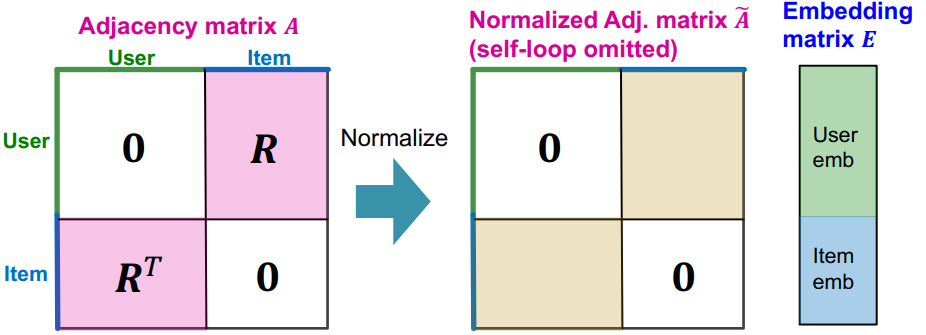
</td><td>

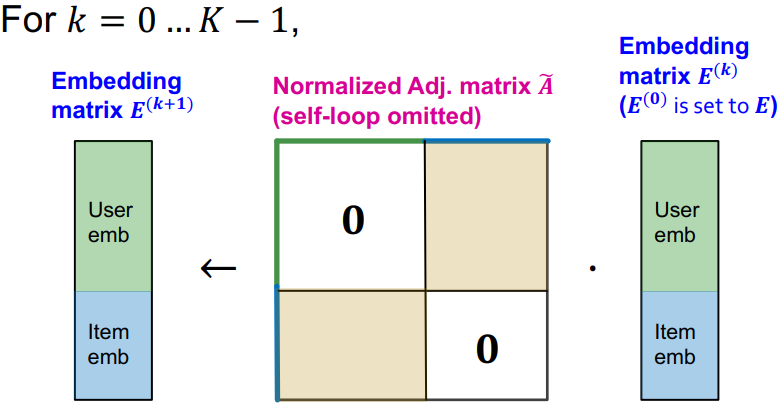
</td><td>

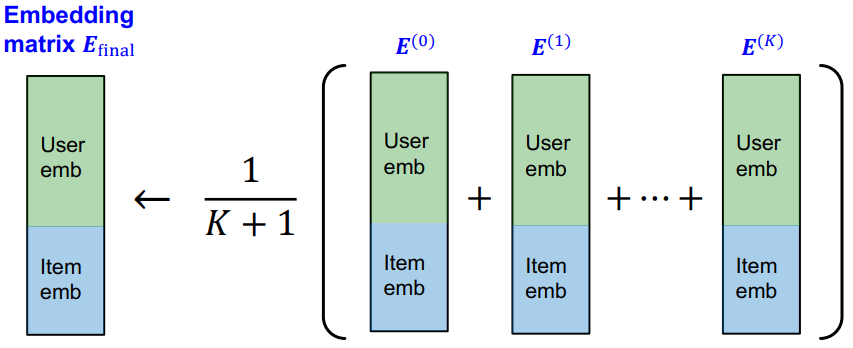
</td></tr></table>

### PinSAGE

## Community Detection in Networks
Mark Granovetter's theory, known as "The Strength of Weak Ties," posits that weak social ties (acquaintances, etc.) rather than close ones (friends, etc.) are crucial for the flow of information and opportunities in social networks. Suggesting networks are then composed of tightly connected clusters (communities, groups, etc.) with strong intra-cluster connections and weak inter-cluster connections, with the edge importance being inveresed to its strength.

Let then the ***modularity***, $Q$, be the measure of how well a network is partitioned into communities; that given a partitioning of the network into disjointed groups $Q$ should be proportional to the number of edges in the partition minus the expected number of edges in teh partition. For the expected number of edges; given real $G$ on $n$ nodes and $m$ edges, construct rewired, multigraph, network $G'$ (same degree distribution but uniformaly random connections), the expected number of edges between nodes $i$ and $j$ of degrees $k_i$ and $k_j$ is $\frac{k_ik_j}{2m}$ ($2m$ directed edges in total). From this then, the *modularity* can be defined as $Q(G,S)=\frac{1}{2m}\sum_{s\in S}\sum_{i\in s}\sum_{j\in s}(A_{ij}-\frac{k_ik_j}{2m})$ ($Q\ge [0.3, 0.7]$ significant community structure).

### Louvain Algorithm
The de facto algorithm to partition networks into clusters ($O(n\log n)$ time complexity), greedily maximises the *modularity* function and thereby finding communities at multiple hierarchical levels (dendogram). Each pass is made of 2 phases:
1. *Modularity* is optimised by allowing only local changes to node-communities memberships. Each node in a graph is placed into a distinct community; and for each node $i$, the algorithm computes the $\Delta Q$ gains when putting node $i$ into the community of its neighbour $j$, repeating it to all of its neighbours and finally placing $i$ into the community of node $j$ which yields the largest gain in $\Delta Q$; repeating until no movement yields a gain. Moving a node $i$ from community $D$ to community $C$ would then yield $\Delta Q(D\rightarrow i\rightarrow C)=\Delta Q(D\rightarrow i)+\Delta Q(i\rightarrow C)$
    - Considering a single cluster $C$, $Q(C)=\frac{1}{2m}\sum_{i\in C}\sum_{j\in C}(A_{ij}-\frac{k_ik_j}{2m})=\frac{\sum_{i\in C}\sum_{j\in C}A_{ij}}{2m}-\frac{\sum_{i\in C}k_i\sum_{j\in C}k_j}{(2m)^2}=\frac{\sum_{i\in C}\sum_{j\in C}A_{ij}}{2m}-(\frac{\sum_{l\in C}k_l}{2m})^2=\frac{\sum_{\text{in}}}{2m}-(\frac{\sum_{\text{total}}}{2m})^2$ which can be interpreted as the proportional number of links within the community minus it's nodes' total links. 
    - Given node $i$ is a single node cluster (without self loops), $Q(\{i\})=\frac{A_{ii}}{2m}-(\frac{k_i}{2m})^2$; then if this node is added to community $C$, $Q(C+\{i\})=\frac{\sum_{\text{in}}+A_{ii}+\sum_{j\in C}A_{ij}}{2m}-(\frac{\sum_{\text{total}}+k_i}{2m})^2$. 
    - Therefore, the *modularity* gain of $\Delta(i\rightarrow C)$ would then be $[\frac{\sum_{\text{in}}+A_{ii}+\sum_{j\in C}A_{ij}}{2m}-(\frac{\sum_{\text{total}}+k_i}{2m})^2]-[\frac{\sum_{\text{in}}}{2m}-(\frac{\sum_{\text{total}}}{2m})^2+\frac{A_{ii}}{2m}-(\frac{k_i}{2m})^2]$; similarly applied to derive $\Delta(D\rightarrow i)$, etc.
2. The identified communities are aggregated into super-nodes to build a new network. Super-nodes are connected if there is at least one edge between the nodes of the corresponding communities, with its weight being the sum of the weights of all edges between their corresponding communities. 

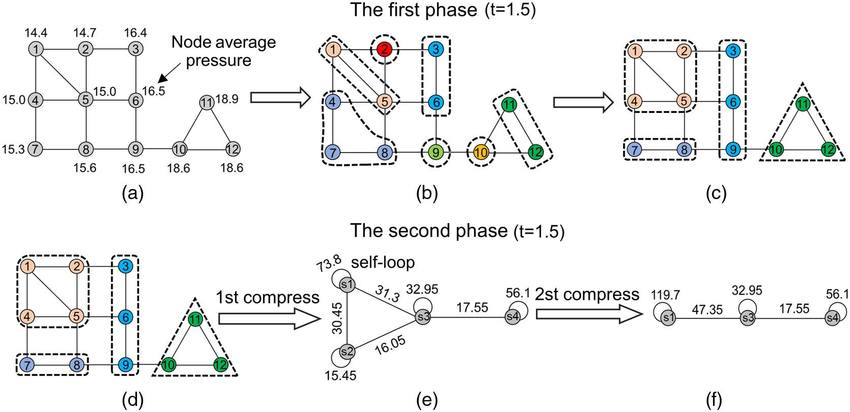